<a href="https://colab.research.google.com/github/eliyahudev/Mannix2/blob/ptq/deit_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
import urllib


In [4]:
class ObserverBase(nn.Module):
    def __init__(self, dtype=torch.qint8, qscheme=torch.per_tensor_affine):
        """
        ObserverBase class is a base class for observers in PyTorch quantization.

        Args:
            dtype (torch.dtype): Data type for quantization, typically `torch.qint8` or `torch.quint8`.
            qscheme (torch.qscheme): Quantization scheme. For example, `torch.per_tensor_affine`.
        """
        super(ObserverBase, self).__init__()
        self.dtype = dtype
        self.qscheme = qscheme
        self.is_symmetric = qscheme in [torch.per_tensor_symmetric, torch.per_channel_symmetric]

    def forward(self, x):
        """
        Placeholder for the forward method that will process the input data (activations or weights).
        To be overridden in derived classes.

        Args:
            x (torch.Tensor): The input tensor to observe.
        """
        raise NotImplementedError("ObserverBase.forward must be implemented in derived classes")

    def calculate_qparams(self):
        """
        Placeholder for the calculate_qparams method. It should calculate the quantization parameters
        (scale and zero point) based on the statistics collected in the forward pass.
        """
        raise NotImplementedError("ObserverBase.calculate_qparams must be implemented in derived classes")

In [ ]:

class MinMaxObserver(ObserverBase):
    def __init__(self, dtype=torch.qint8, qscheme=torch.per_tensor_affine, nof_bits=8, is_calibrate=False):
        """
        MinMaxObserver class is used to record the minimum and maximum values of the input activations.
        These values will be used to compute the scale and zero-point for quantization.

        Args:
            dtype (torch.dtype): The data type for quantization, e.g., torch.qint8.
            qscheme (torch.qscheme): The quantization scheme, e.g., torch.per_tensor_affine.
            nof_bits (int): Number of bits for quantization.
            is_calibrate (bool): Flag indicating whether to calculate the scale and zero-point during forwarding.
        """
        super(MinMaxObserver, self).__init__()
        self.dtype = dtype
        self.qscheme = qscheme
        self.nof_bits = nof_bits
        self.is_calibrate = is_calibrate
        self.min_val = torch.tensor(float('inf'))  # Initialize min with infinity
        self.max_val = torch.tensor(float('-inf'))  # Initialize max with -infinity
        self.scale = None
        self.zero_point = None

    def forward(self, x):
        """
        This method updates the minimum and maximum values by comparing the current min and max
        with those in the input tensor. If is_calibrate is True, it calculates the scale and zero-point.

        Args:
            x (torch.Tensor): The input tensor to observe.
        """
        global_min = x.min()
        global_max = x.max()

        if global_min < self.min_val:
            self.min_val = global_min
        if global_max > self.max_val:
            self.max_val = global_max

        # Calculate scale and zero-point during forwarding if is_calibrate is True
        self.calculate_qparams()

            # print("Global min:", self.min_val.item())
            # print("Global max:", self.max_val.item())
        return x

    def calculate_qparams(self):
        """
        This method computes the scale and zero-point for quantization based on the min and max values
        observed during the forward pass.

        Returns:
            scale (torch.Tensor): The quantization scale.
            zero_point (torch.Tensor): The quantization zero-point.
        """
        if self.min_val == self.max_val:
            # To handle cases where min == max to avoid division by zero
            self.scale = torch.tensor([1.0], dtype=torch.float32)
            self.zero_point = torch.tensor([0], dtype=torch.int32)
        else:
            # Calculate scale and zero-point for qint8 quantization
            self.scale = (self.max_val - self.min_val) / (2 ** self.nof_bits - 1)
            if self.qscheme == torch.per_tensor_affine:
                self.zero_point = torch.round(-self.min_val / self.scale).clamp(0, 2 ** self.nof_bits - 1)
            else:
                self.zero_point = 0
        return self.scale, self.zero_point

    def quantizer(self, x):
        """
        Quantizes the input tensor using the calculated scale and zero-point.

        Args:
            x (torch.Tensor): The input tensor to quantize.

        Returns:
            torch.Tensor: The quantized tensor.
        """
        # if self.is_calibrate:
        if self.scale is None or self.zero_point is None:
            raise ValueError("Scale and zero-point must be calculated before quantizing.")

        # Quantize the input
        if self.qscheme == torch.per_tensor_affine:
            x_q = (x / self.scale + self.zero_point).round().clamp(0, 2 ** self.nof_bits - 1)
        else:
            x_q = (x / self.scale + self.zero_point).round().clamp(-2 ** (self.nof_bits-1), 2 ** (self.nof_bits-1) - 1)

        return x_q.int()
        # else:
        #     return x

    def dequantizer(self, x_q):
        """
        Dequantizes the input tensor using the calculated scale and zero-point.

        Args:
            x_q (torch.Tensor): The quantized tensor to dequantize.

        Returns:
            torch.Tensor: The dequantized tensor.
        """
        if self.scale is None or self.zero_point is None:
            raise ValueError("Scale and zero-point must be calculated before dequantizing.")

        # Dequantize the input
        x_fp = self.scale * (x_q.float() - self.zero_point)
        return x_fp


In [ ]:
class QuantizedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.qint8, qscheme=torch.per_tensor_affine, nof_bits=8, is_calibrate=False):
        """
        A quantized version of nn.Linear that uses MinMaxObserver to quantize weights, bias, and inputs.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            bias (bool): If set to False, the layer will not learn an additive bias. Default: True.
            dtype (torch.dtype): Data type for quantization, typically qint8 or quint8.
            qscheme (torch.qscheme): Quantization scheme, typically per_tensor_affine.
            nof_bits (int): Number of bits for quantization.
            is_calibrate (bool): If True, the observer will update min/max values but not quantize the input.
        """
        super(QuantizedLinear, self).__init__(in_features, out_features, bias)

        # Initialize observers for inputs, weights, and bias
        self.in_obs = MinMaxObserver(qscheme=torch.per_tensor_affine, nof_bits=8, is_calibrate=True)
        self.w_obs = MinMaxObserver(qscheme=torch.per_tensor_symmetric, nof_bits=8, is_calibrate=True)
        self.b_obs = MinMaxObserver(qscheme=torch.per_tensor_symmetric, nof_bits=16, is_calibrate=True)

        self.is_calibrate = is_calibrate
        self.is_weights_quantized = False  # Track whether weights have been quantized
        self.quant = True  # Control whether to perform quantized operations

    def forward(self, x):
        """
        Forward pass through the quantized linear layer.
        If is_calibrate is True, update the min/max values of the input observer without performing quantization.
        Otherwise, quantize the input, weights, and bias, perform integer-based linear operation, and dequantize the result.

        Args:
            x (torch.Tensor): Input tensor to the linear layer.

        Returns:
            torch.Tensor: Dequantized output after quantized linear transformation.
        """
        # Calibration mode: update the input observer and return the input tensor as-is
        if self.is_calibrate:
            self.in_obs(x)
            output = F.linear(x, self.weight, self.bias)
            return output

        # Quantize weights and bias if not already done
        if not self.is_weights_quantized:
            # Quantize the weights
            self.w_obs(self.weight)
            self.scale_weight, self.zero_point_weight = self.w_obs.calculate_qparams()
            self.weight_integer = self.w_obs.quantizer(self.weight)

            # Quantize the bias if it exists
            if self.bias is not None:
                # Calculate bias quantization scale as the product of input and weight scales
                self.b_obs.scale = self.in_obs.scale * self.w_obs.scale
                self.b_obs.zero_point = 0  # Bias zero-point is typically set to 0

                # Quantize the bias
                self.bias_integer = self.b_obs.quantizer(self.bias)
            else:
                # needs to dequantize the output
                self.b_obs.scale = self.in_obs.scale * self.w_obs.scale
                self.b_obs.zero_point = 0  # Bias zero-point is typically set to 0
                self.bias_integer = None

            self.is_weights_quantized = True  # Weights and bias are now quantized

        # Apply the linear transformation in the quantized domain using integer arithmetic
        if self.quant:
            # Quantize the input
            self.scale_input, self.zero_point_input = self.in_obs.calculate_qparams()
            x_q = self.in_obs.quantizer(x)
            x_q = x_q - self.zero_point_input.int()
            # Integer linear transformation (input, weights, and bias are all quantized)
            output_q = F.linear(x_q.float(),
                                weight=self.weight_integer.float(),
                                bias=self.bias_integer.float())

            # Dequantize the output
            dq_output = self.b_obs.dequantizer(output_q)
            return dq_output
        else:
            # If quantization is disabled, perform a standard floating-point linear operation
            output = F.linear(x, self.weight, self.bias)
            return output

    def set_calibration_flag(self):
        self.is_calibrate = True
    def unset_calibration_flag(self):
        self.is_calibrate = False

In [ ]:
class IntSoftmaxTS(nn.Module):
    """
    Quantized Softmax with a combination of Lookup Table (LUT) approximation and Taylor Series expansion.
    This class uses integer-only arithmetic to perform the softmax function with quantized inputs.

    The core approximation is done through:
    - A Taylor series expansion for both the logarithm (ln) and exponential (exp) functions.
    - Lookup Table (LUT) usage is combined with Taylor series to speed up certain approximations.
    """

    def __init__(self, quant=False, is_calibrate=False):
        """
        Initializes the quantized softmax class.

        Args:
            quant (bool): Flag indicating whether to perform quantization.
            is_calibrate (bool): Calibration mode for quantization.
        """
        super(IntSoftmaxTS, self).__init__()

        # LUT size and quantization configuration
        self.LUT_SIZE = 16  # Size of the lookup table (LUT)
        self.nof_bits = 16  # Number of bits for quantization
        self.log_scale = 16  # Log scale to replace the division
        self.relog_scale = 8  # exp scale for conversion back from log-domaion
        self.iterations = 2  # Number of iterations for the Taylor series expansion

        self.quant = quant  # Whether quantization is used
        self.is_calibrate = is_calibrate  # Whether the module is in calibration mode

    @staticmethod
    def ts_ln(in_x, ev_point=-1, nof_bits=16, iterations=3, LUT_SIZE=16):
        """
        Approximate natural logarithm (ln) using a Taylor series expansion around evaluation points.

        Args:
            in_x (torch.Tensor): Input tensor.
            ev_point (int): Evaluation point for the Taylor series expansion. Default is -1 (automatically determined).
            nof_bits (int): Number of bits for quantization.
            iterations (int): Number of iterations for the Taylor series expansion.
            LUT_SIZE (int): Size of the lookup table (LUT).

        Returns:
            torch.Tensor: Approximated logarithmic value using Taylor series.
        """
        scale = 1 << (nof_bits - 1)  # Scaling factor based on bit size
        offset = torch.round(in_x / scale).int() if ev_point == -1 else torch.tensor(ev_point)

        # Start Taylor series for log with logarithmic approximation at the evaluation point
        sum_result = (torch.log(offset + 1e-5) * scale).int()  # Prevent log(0) by adding a small value
        x_pow = ((in_x - (offset * scale).int()) * (scale / offset)).int() // scale
        sum_result += x_pow

        # Perform iterative Taylor series expansion for higher-order terms
        sign = -1
        for i in range(2, iterations + 1):
            x_pow = (x_pow * x_pow).int() // (scale * i)
            sum_result += sign * x_pow
            sign *= -1  # Alternate between addition and subtraction

        return (sum_result / scale).float()

    @staticmethod
    def int_exp(in_x, nof_bits, iterations, LUT_SIZE):
        """
        Approximate exponential function (exp) using a Taylor series expansion around evaluation points.

        Args:
            in_x (torch.Tensor): Input tensor.
            nof_bits (int): Number of bits for quantization.
            iterations (int): Number of iterations for the Taylor series expansion.
            LUT_SIZE (int): Size of the lookup table (LUT).

        Returns:
            torch.Tensor: Approximated exponential value using Taylor series.
        """
        scale = 1 << (nof_bits - 1)  # Scaling factor based on bit size
        sum_result = scale  # Start with the first term of the Taylor series (1)

        # Initialize x_pow for the Taylor series expansion
        offset = torch.round(in_x).int()
        x_pow = (in_x * scale).int() - (offset * scale).int()
        sum_result += x_pow

        # Perform iterative Taylor series expansion for higher-order terms
        for i in range(2, iterations + 1):
            x_pow = (x_pow * ((in_x * scale).int() - (offset * scale).int())) // (scale * i)
            sum_result += x_pow

        # Multiply the sum by the exponential of the offset to get the final approximation
        sum_result *= torch.floor(torch.exp(offset) * scale).int()
        return torch.floor(sum_result / scale)

    @staticmethod
    def int_softmax(x, nof_bits, iterations, LUT_SIZE):
        """
        Integer-only softmax function using Taylor series expansion for exp and LUT for ln.

        Args:
            x (torch.Tensor): Input tensor.
            nof_bits (int): Number of bits for quantization.
            iterations (int): Number of iterations for the Taylor series expansion.
            LUT_SIZE (int): Lookup table size for approximation.

        Returns:
            torch.Tensor: Approximated softmax values using integer arithmetic.
        """
        # Subtract the maximum value for numerical stability during softmax computation
        x_int = x - x.max(dim=-1, keepdim=True).values

        # Approximate the exponential function for softmax computation
        exp_int = IntSoftmaxTS.int_exp(x_int, nof_bits, iterations, LUT_SIZE)
        exp_int_sum = exp_int.sum(dim=-1, keepdim=True)

        return exp_int, exp_int_sum

    def forward(self, x):
        """
        Forward pass for quantized softmax with LUT and Taylor Series approximations.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Dequantized softmax output.
        """
        # Compute the integer-based softmax
        exp_int, exp_int_sum = self.int_softmax(x, self.nof_bits, self.iterations, self.LUT_SIZE)

        # Approximate the logarithmic summation using Taylor series
        ln_sum = self.ts_ln(exp_int_sum, iterations=4, nof_bits=self.log_scale)
        ln_mul = self.int_exp(-ln_sum, self.relog_scale, 2, 16)

        # Dequantize the result to return floating-point values
        # deq_softmax = exp_int / exp_int_sum.float()
        deq_softmax = (ln_mul * exp_int) / (1 << ((self.log_scale-1)+(self.relog_scale-1)))
        return deq_softmax

In [ ]:
class QuantizedMatmul(nn.Module):
    """
    A quantized matrix multiplication layer using integer-only arithmetic for efficiency.
    This class uses MinMaxObserver to quantize inputs and perform matrix multiplication in the quantized domain.
    """

    def __init__(self, bias=True, is_calibrate=False):
        """
        Initializes the quantized matrix multiplication layer.

        Args:
            bias (bool): If set to False, the layer will not use bias. Default: True.
            is_calibrate (bool): Flag for enabling calibration mode to update observers.
        """
        super(QuantizedMatmul, self).__init__()

        # Initialize observers for two input tensors and the output
        self.in1_obs = MinMaxObserver(qscheme=torch.per_tensor_affine, nof_bits=8, is_calibrate=is_calibrate)
        self.in2_obs = MinMaxObserver(qscheme=torch.per_tensor_affine, nof_bits=8, is_calibrate=is_calibrate)
        self.out_obs = MinMaxObserver(qscheme=torch.per_tensor_symmetric, nof_bits=16, is_calibrate=is_calibrate)

        self.is_calibrate = is_calibrate
        self.quant = True  # Whether to use quantized operations
        self.is_output_quantized = False  # Track if output has been quantized

    def forward(self, x1, x2):
        """
        Forward pass for matrix multiplication.

        Args:
            x1 (torch.Tensor): The first input tensor.
            x2 (torch.Tensor): The second input tensor.

        Returns:
            torch.Tensor: Result of matrix multiplication, either quantized or floating-point.
        """
        # Calibration mode: update observers with input min/max values
        if self.is_calibrate:
            self.in1_obs(x1)
            self.in2_obs(x2)
            return x1 @ x2  # Return the floating-point result during calibration

        # Quantized matrix multiplication
        if self.quant:
            # Quantize the inputs
            scale_input1, zero_point_input1 = self.in1_obs.calculate_qparams()
            scale_input2, zero_point_input2 = self.in2_obs.calculate_qparams()

            # Quantize the inputs based on their scales and zero points
            x_q1 = self.in1_obs.quantizer(x1)
            x_q2 = self.in2_obs.quantizer(x2)

            # Output quantization initialization
            if not self.is_output_quantized:
                self.out_obs.scale = scale_input1 * scale_input2
                self.out_obs.zero_point = 0  # Default zero-point for the output
                self.is_output_quantized = True

            # Perform quantized matrix multiplication
            output_q = (x_q1 - zero_point_input1) @ (x_q2 - zero_point_input2)

            # Dequantize the output
            dq_output = self.out_obs.dequantizer(output_q)
            return dq_output
        else:
            # Standard floating-point matrix multiplication
            return x1 @ x2

    def set_calibration_flag(self):
        """Enable calibration mode to update observers."""
        self.is_calibrate = True

    def unset_calibration_flag(self):
        """Disable calibration mode."""
        self.is_calibrate = False

In [ ]:
class qHadamardProd(nn.Module):
    """
    A quantized matrix multiplication layer using integer-only arithmetic for efficiency.
    This class uses MinMaxObserver to quantize inputs and perform matrix multiplication in the quantized domain.
    """

    def __init__(self, bias=True, is_calibrate=False):
        """
        Initializes the quantized matrix multiplication layer.

        Args:
            bias (bool): If set to False, the layer will not use bias. Default: True.
            is_calibrate (bool): Flag for enabling calibration mode to update observers.
        """
        super(qHadamardProd, self).__init__()

        # Initialize observers for two input tensors and the output
        self.in1_obs = MinMaxObserver(qscheme=torch.per_tensor_affine, nof_bits=8, is_calibrate=is_calibrate)
        self.in2_obs = MinMaxObserver(qscheme=torch.per_tensor_affine, nof_bits=8, is_calibrate=is_calibrate)
        self.out_obs = MinMaxObserver(qscheme=torch.per_tensor_symmetric, nof_bits=16, is_calibrate=is_calibrate)

        self.is_calibrate = is_calibrate
        self.quant = True  # Whether to use quantized operations
        self.is_output_quantized = False  # Track if output has been quantized

    def forward(self, x1, x2):
        """
        Forward pass for matrix multiplication.

        Args:
            x1 (torch.Tensor): The first input tensor.
            x2 (torch.Tensor): The second input tensor.

        Returns:
            torch.Tensor: Result of matrix multiplication, either quantized or floating-point.
        """
        # Calibration mode: update observers with input min/max values
        if self.is_calibrate:
            self.in1_obs(x1)
            self.in2_obs(x2)
            return x1 * x2  # Return the floating-point result during calibration

        # Quantized matrix multiplication
        if self.quant:
            # Quantize the inputs
            scale_input1, zero_point_input1 = self.in1_obs.calculate_qparams()
            scale_input2, zero_point_input2 = self.in2_obs.calculate_qparams()

            # Quantize the inputs based on their scales and zero points
            x_q1 = self.in1_obs.quantizer(x1)
            x_q2 = self.in2_obs.quantizer(x2)

            # Output quantization initialization
            if not self.is_output_quantized:
                self.out_obs.scale = scale_input1 * scale_input2
                self.out_obs.zero_point = 0  # Default zero-point for the output
                self.is_output_quantized = True

            # Perform quantized matrix multiplication
            output_q = (x_q1 - zero_point_input1) * (x_q2 - zero_point_input2)

            # Dequantize the output
            dq_output = self.out_obs.dequantizer(output_q)
            return dq_output
        else:
            # Standard floating-point matrix multiplication
            return x1 * x2

    def set_calibration_flag(self):
        """Enable calibration mode to update observers."""
        self.is_calibrate = True

    def unset_calibration_flag(self):
        """Disable calibration mode."""
        self.is_calibrate = False

In [ ]:
class IntGeluTS(nn.Module):
    """
    Quantized Softmax with a combination of Lookup Table (LUT) approximation and Taylor Series expansion.
    This class uses integer-only arithmetic to perform the softmax function with quantized inputs.

    The core approximation is done through:
    - A Taylor series expansion for both the logarithm (ln) and exponential (exp) functions.
    - Lookup Table (LUT) usage is combined with Taylor series to speed up certain approximations.
    """

    def __init__(self, quant=False, is_calibrate=False):
        """
        Initializes the quantized softmax class.

        Args:
            quant (bool): Flag indicating whether to perform quantization.
            is_calibrate (bool): Calibration mode for quantization.
        """
        super(IntGeluTS, self).__init__()

        # LUT size and quantization configuration
        self.LUT_SIZE = 16  # Size of the lookup table (LUT)
        self.nof_bits = 16  # Number of bits for quantization
        self.log_scale = 16  # Log scale to replace the division
        self.relog_scale = 8  # exp scale for conversion back from log-domaion
        self.iterations = 2  # Number of iterations for the Taylor series expansion

        self.quant = quant  # Whether quantization is used
        self.is_calibrate = is_calibrate  # Whether the module is in calibration mode
        self.had_mul = qHadamardProd()
    @staticmethod
    def ts_ln(in_x, ev_point=-1, nof_bits=16, iterations=3, LUT_SIZE=16):
        """
        Approximate natural logarithm (ln) using a Taylor series expansion around evaluation points.

        Args:
            in_x (torch.Tensor): Input tensor.
            ev_point (int): Evaluation point for the Taylor series expansion. Default is -1 (automatically determined).
            nof_bits (int): Number of bits for quantization.
            iterations (int): Number of iterations for the Taylor series expansion.
            LUT_SIZE (int): Size of the lookup table (LUT).

        Returns:
            torch.Tensor: Approximated logarithmic value using Taylor series.
        """
        scale = 1 << (nof_bits - 1)  # Scaling factor based on bit size
        offset = torch.round(in_x / scale).int() if ev_point == -1 else torch.tensor(ev_point)

        # Start Taylor series for log with logarithmic approximation at the evaluation point
        sum_result = (torch.log(offset + 1e-5) * scale).int()  # Prevent log(0) by adding a small value
        x_pow = ((in_x - (offset * scale).int()) * (scale / offset)).int() // scale
        sum_result += x_pow

        # Perform iterative Taylor series expansion for higher-order terms
        sign = -1
        for i in range(2, iterations + 1):
            x_pow = (x_pow * x_pow).int() // (scale * i)
            sum_result += sign * x_pow
            sign *= -1  # Alternate between addition and subtraction

        return (sum_result / scale).float()

    @staticmethod
    def int_exp(in_x, nof_bits, iterations, LUT_SIZE):
        """
        Approximate exponential function (exp) using a Taylor series expansion around evaluation points.

        Args:
            in_x (torch.Tensor): Input tensor.
            nof_bits (int): Number of bits for quantization.
            iterations (int): Number of iterations for the Taylor series expansion.
            LUT_SIZE (int): Size of the lookup table (LUT).

        Returns:
            torch.Tensor: Approximated exponential value using Taylor series.
        """
        scale = 1 << (nof_bits - 1)  # Scaling factor based on bit size
        sum_result = scale  # Start with the first term of the Taylor series (1)

        # Initialize x_pow for the Taylor series expansion
        offset = torch.round(in_x).int()
        x_pow = (in_x * scale).int() - (offset * scale).int()
        sum_result += x_pow

        # Perform iterative Taylor series expansion for higher-order terms
        for i in range(2, iterations + 1):
            x_pow = (x_pow * ((in_x * scale).int() - (offset * scale).int())) // (scale * i)
            sum_result += x_pow

        # Multiply the sum by the exponential of the offset to get the final approximation
        sum_result *= torch.floor(torch.exp(offset) * scale).int()
        return torch.floor(sum_result / scale)

    @staticmethod
    def int_sigmoid(x, nof_bits, iterations, LUT_SIZE):
        """
        Integer-only softmax function using Taylor series expansion for exp and LUT for ln.

        Args:
            x (torch.Tensor): Input tensor.
            nof_bits (int): Number of bits for quantization.
            iterations (int): Number of iterations for the Taylor series expansion.
            LUT_SIZE (int): Lookup table size for approximation.

        Returns:
            torch.Tensor: Approximated softmax values using integer arithmetic.
        """
        # Subtract the maximum value for numerical stability during softmax computation
        x_sig = x * 1.702
        x_max = torch.clamp(x_sig, min=0)
        x_int = x_sig - x_max

        # Approximate the exponential function for softmax computation
        exp_int = IntGeluTS.int_exp(x_int, nof_bits, iterations, LUT_SIZE)
        exp_zero = IntGeluTS.int_exp(-x_max, nof_bits, iterations, LUT_SIZE)
        exp_int_sum = exp_int + exp_zero

        return exp_int, exp_int_sum

    def forward(self, x):
        """
        Forward pass for quantized softmax with LUT and Taylor Series approximations.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Dequantized softmax output.
        """
        # Compute the integer-based softmax
        exp_int, exp_int_sum = self.int_sigmoid(x, self.nof_bits, self.iterations, self.LUT_SIZE)

        # Approximate the logarithmic summation using Taylor series
        ln_sum = self.ts_ln(exp_int_sum, iterations=4, nof_bits=self.log_scale)
        ln_mul = self.int_exp(-ln_sum, self.relog_scale, 2, 16)

        # Dequantize the result to return floating-point values
        # deq_softmax = exp_int / exp_int_sum.float()
        deq_sigmoid = (ln_mul * exp_int) / (1 << ((self.log_scale-1)+(self.relog_scale-1)))
        output = self.had_mul(x, deq_sigmoid)
        # output = self.x * deq_sigmoid
        return output

In [ ]:
class Mlp(nn.Module):
    """ Feed-forward network (MLP) block used in Transformer blocks """
    def __init__(self, in_features,
                 hidden_features=None,
                 out_features=None,
                 act_layer=nn.GELU,
                 is_calibrate=False,
                 drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = QuantizedLinear(in_features, hidden_features)
        # self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = QuantizedLinear(hidden_features, out_features)
        # self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    """ Multi-head self-attention mechanism """
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = QuantizedLinear(dim, dim * 3, bias=qkv_bias)
        self.mat_mul_qk = QuantizedMatmul()
        self.sf = IntSoftmaxTS()
        # self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.mat_mul_pv = QuantizedMatmul()
        self.proj = QuantizedLinear(dim, dim)
        # self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Split into query, key, and value tensors
        attn = self.mat_mul_qk(q, k.transpose(-2, -1)) * self.scale  # Scaled dot-product attention
        # attn = (q @ k.transpose(-2, -1)) * self.scale  # Scaled dot-product attention
        attn = self.sf(attn)
        attn = self.attn_drop(attn)

        x = self.mat_mul_pv(attn, v).transpose(1, 2).reshape(B, N, C)
        # x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):
    """ Transformer Block: Multi-head Attention + MLP + LayerNorm """
    def __init__(self,
                 embed_dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 is_calibrate = False,
                 act_layer=IntGeluTS,
                 # act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(embed_dim)
        self.attn = Attention(
            embed_dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # Drop path layer for stochastic depth (not always needed)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = Mlp(in_features=embed_dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))  # Residual connection after attention
        x = x + self.drop_path(self.mlp(self.norm2(x)))   # Residual connection after MLP
        return x


# Helper class for DropPath (Stochastic Depth)
class DropPath(nn.Module):
    """ Drop paths (stochastic depth) per sample (when applied in main path of residual blocks). """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """ Drop paths (Stochastic Depth) per sample (batch-wise) """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding

    Args:
        img_size (int): Input image size.
        patch_size (int): Size of the patch to split the image into.
        in_chans (int): Number of input image channels (e.g., 3 for RGB).
        embed_dim (int): Dimensionality of the embedding space.
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2  # Number of patches in the image

        # A convolution layer to split the image into patches and project them into the embedding space
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        Args:
            x (Tensor): Shape (batch_size, in_chans, img_size, img_size)
        Returns:
            Patch embeddings: Shape (batch_size, num_patches, embed_dim)
        """
        # Shape after conv: (batch_size, embed_dim, grid_size, grid_size)
        x = self.proj(x)

        # Flatten the patches and change the shape to (batch_size, num_patches, embed_dim)
        x = x.flatten(2)  # Shape (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # Shape (batch_size, num_patches, embed_dim)

        return x


In [ ]:
class DistilledVisionTransformer(nn.Module):
    def __init__(self, img_size=224,
                 patch_size=16,
                 in_chans=3,
                 num_classes=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 distilled=True,
                 is_calibrate = False,
                 **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=0.1)

        self.blocks = nn.ModuleList([
            Block(embed_dim=embed_dim,
                  num_heads=num_heads,
                  mlp_ratio=mlp_ratio,
                  qkv_bias=qkv_bias,
                  is_calibrate=False,
                  **kwargs)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = nn.Linear(embed_dim, num_classes) if distilled else None

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # Class token
        if self.dist_token is None:
            x = torch.cat((cls_tokens, x), dim=1)
        else:
            dist_token = self.dist_token.expand(B, -1, -1)  # Distillation token
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        if self.dist_token is None:
            return x[:, 0]  # return class token output
        else:
            return x[:, 0], x[:, 1]  # return class token and distillation token

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x_cls, x_dist = x
            x = self.head(x_cls), self.head_dist(x_dist)  # Class and distillation heads
            if not self.training:
                # during inference, return the average of both head outputs
                return (x[0] + x[1]) / 2
            else:
                return x
        else:
            x = self.head(x)
        return x

    def set_calibration_flag(self):
        for m in self.modules():
            if type(m) in [QuantizedLinear, QuantizedMatmul, qHadamardProd]:
                m.set_calibration_flag()

    def unset_calibration_flag(self):
        for m in self.modules():
            if type(m) in [QuantizedLinear, QuantizedMatmul, qHadamardProd]:
                m.unset_calibration_flag()


def deit_base_patch16_224(pretrained=False, **kwargs):
    model = DistilledVisionTransformer(
        img_size=224, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        distilled=False,  # Disable distillation
        **kwargs)
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            'https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth', map_location='cpu')
        model.load_state_dict(checkpoint['model'])
    return model

# Initialize model

In [ ]:
model = deit_base_patch16_224(pretrained=True)
# device = torch.device("cpu")
device = torch.device("cuda:0")  # select device to use
model = model.to(device)
model.eval()  # Set the model to evaluation mode

DistilledVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): QuantizedLinear(
          in_features=768, out_features=2304, bias=True
          (in_obs): MinMaxObserver()
          (w_obs): MinMaxObserver()
          (b_obs): MinMaxObserver()
        )
        (mat_mul_qk): QuantizedMatmul(
          (in1_obs): MinMaxObserver()
          (in2_obs): MinMaxObserver()
          (out_obs): MinMaxObserver()
        )
        (sf): IntSoftmaxTS()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (mat_mul_pv): QuantizedMatmul(
          (in1_obs): MinMaxObserver()
          (in2_obs): MinMaxObserver()
          (out_obs): MinMaxObserver()
        )
        (proj): QuantizedLinear(
          in_features=768, out_features=7

In [ ]:
load_dataset_flag = 0
try:
    if load_dataset_flag:
        pass
    else:
        raise NameError
except NameError as err:

        # Create stream set for validation and calibration
        print("loading calibration dataset (huggingface server)...")
        dset_calib = load_dataset('imagenet-1k',split='train',
                                  streaming=True,
                                  token=True,
                                  trust_remote_code=True
        #                          ).shuffle(seed=42).take(100)
                                 ).shuffle(seed=42).take(100)
        print("done")

        print("loading imagenet-1k test dataset from huggingface server...")
        dset_infer = load_dataset('imagenet-1k',split='validation',
                                  streaming=True,
                                  token=True,
                                  trust_remote_code=True
        #                          ).shuffle(seed=42).take(100)
                                 ).shuffle(seed=42)
        print("done")

        # Image preprocessing
        preprocess = transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Convert grayscale to RGB
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        def fit_image(tst):
            # tst["sentence1"] = 'My sentence: ' + tst["sentence1"]
            # print("what the hell happened")
            tst['image'] = preprocess(tst['image'])
            tst['label'] = tst['label']
            # print("test")
            return tst

        dset_calib_updated = dset_infer.map(fit_image)

        print("Building a calibration loader...")
        val_loader = torch.utils.data.DataLoader(
            dset_calib_updated,
            batch_size=2,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
        )

        it = iter(dset_infer)
        load_dataset_flag = 1

        print("done")


loading calibration dataset (huggingface server)...
done
loading imagenet-1k test dataset from huggingface server...
done
Building a calibration loader...
done


In [ ]:
def fit_image(tst):
    # tst["sentence1"] = 'My sentence: ' + tst["sentence1"]
    # print("what the hell happened")
    tst['image'] = preprocess(tst['image'])
    tst['label'] = tst['label']
    # print("test")
    return tst


# del image_list  # recreate a new dataset
try:
    if image_list:
        pass
    else:
        raise NameError
except NameError as err:
    print("loading dataset from huggingface server...")
    dset_calib = load_dataset('imagenet-1k',split='train',
                              streaming=True,
                              token=True,
                              trust_remote_code=True
    #                          ).shuffle(seed=42).take(100)
                             ).shuffle(seed=42)
    print("done")
    print("create a preprocessing transform")
    # fit_image = preprocess
    dset_calib_updated = dset_calib.map(fit_image)
    print("done")

    print("Building a data loader...")
    train_loader = torch.utils.data.DataLoader(
        dset_calib_updated,
        batch_size=2,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    print("done")

    # Get N (args.calib_iter) labeled images for the calibration set.
    print("Building calibration set...")
    image_list = []
    for i, info in enumerate(train_loader):
        data, target = info['image'], info['label']
        if i == 100:
            print("break")
            break
        print(i, end="|")
        data = data.to(device)
        image_list.append(data)

    print("done")

    # Download ImageNet class index
    url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
    response = urllib.request.urlopen(url)
    imagenet_classes = [line.strip() for line in response.readlines()]
    print("done")

print("Quantizing model...")
# Use the stream data set to calibrate the quantized model
# model.model_open_calibrate()
with torch.no_grad():
    model.set_calibration_flag()
    print()
    for i, image in enumerate(image_list):

        # if i == len(image_list) - 1:
            # This is used for OMSE method to
            # calculate minimum quantization error
            # model.model_open_last_calibrate()
        print(i, end="|")
        output = model(image)
        # if i == 1:
            # break
    model.unset_calibration_flag()
    print()
print("All done")

loading dataset from huggingface server...
done
create a preprocessing transform
done
Building a data loader...
done
Building calibration set...
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|break
done
done
Quantizing model...

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|
All done


# One image test

In [ ]:
info = next(it)
data = info['image']
label = info['label']
# print(data, label)
print("label:", label)

label: 998


In [ ]:
# Load an image and convert to RGB if necessary
input_tensor = preprocess(data).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

# Forward pass through the model
with torch.no_grad():
    output = model(input_tensor)

# Get predicted class
predicted_class = output.argmax(dim=-1).item()
print(f"Predicted class index: {predicted_class}")

# Map the predicted class index to the label
predicted_label = imagenet_classes[predicted_class]
print(f"Predicted label: {predicted_label}")

Predicted class index: 987
Predicted label: b'corn'


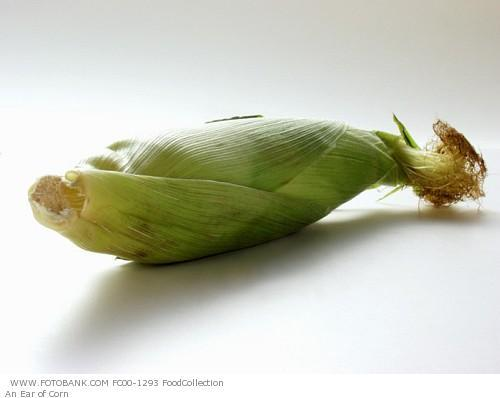

In [ ]:
data

# Model validation

In [ ]:
import time

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
def accuracy(output, target, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [ ]:
def validate(val_loader, model, criterion, device, samples=-1):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    val_start_time = end = time.time()

    for i, info in enumerate(val_loader):

        data, target = info['image'], info['label']
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            output = model(data)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data.item(), data.size(0))
        top1.update(prec1.data.item(), data.size(0))
        top5.update(prec5.data.item(), data.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # if i % args.print_freq == 0:
        if i % 100 == 0:
            print('Test: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i,
                    "dont care",
                    # len(val_loader),
                    batch_time=batch_time,
                    loss=losses,
                    top1=top1,
                    top5=top5,
                ))
        if samples == i:
            print(f"validation is finished (samples {samples})")
            break
    val_end_time = time.time()
    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Time {time:.3f}'.
            format(top1=top1, top5=top5, time=val_end_time - val_start_time))


    return losses.avg, top1.avg, top5.avg

In [ ]:
## Model inference
is_inference = 1  # TODO change to '1' whem running inference

if is_inference:
    if torch.cuda.is_available():
        device = torch.device("cuda")  # Use GPU
        print("GPU is available.")
    else:
        device = torch.device("cpu")  # Use CPU
        print("GPU is not available, using CPU.")

    # Move the model to GPU(s)
    # model = model.to(device)
    # print("loading imagenet-1k test dataset from huggingface server...")
    # dset_infer = load_dataset('imagenet-1k',split='validation',
    #                           streaming=True,
    #                           token=True,
    #                           trust_remote_code=True
    # #                          ).shuffle(seed=42).take(100)
    #                          ).shuffle(seed=42)
    # print("done")

    # print("create a preprocessing transform")
    # # fit_image = tranform_data(args.model.split('_')[0])
    # dset_infer_updated = dset_infer.map(fit_image)
    # print("done")

    # print("Building a data loader...")
    # infer_loader = torch.utils.data.DataLoader(
    #     dset_infer_updated,
    #     batch_size=2,
    #     shuffle=False,
    #     num_workers=0,
    #     pin_memory=True,

    # )
    # print("done")

    # define loss function (criterion)
    try:
        criterion = nn.CrossEntropyLoss().to(device)
        print('Validating...')
        # val_loss, val_prec1, val_prec5 = validate(infer_loader, model,
        val_loss, val_prec1, val_prec5 = validate(val_loader, model,
                                                    criterion, device)
    except KeyboardInterrupt:
        print("stopped by a Keyboard Interrupt")
    finally:
        device = torch.device("cpu")  # Use CPU


GPU is available.
Validating...
Test: [0/dont care]	Time 87.121 (87.121)	Loss 0.5371 (0.5371)	Prec@1 50.000 (50.000)	Prec@5 100.000 (100.000)
Test: [100/dont care]	Time 0.903 (1.927)	Loss 0.2050 (1.0551)	Prec@1 100.000 (78.218)	Prec@5 100.000 (93.069)
Test: [200/dont care]	Time 0.923 (1.492)	Loss 1.2225 (0.9897)	Prec@1 50.000 (78.607)	Prec@5 100.000 (93.781)
stopped by a Keyboard Interrupt


In [ ]:
print(torch.cuda.device_count(), "GPUs available")

1 GPUs available
